<a href="https://colab.research.google.com/github/BigDave07/Spotify-Hit-Predictor/blob/main/Spotify_hit_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# day 17  Spotify_hit_predictor
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

np.random.seed(42)
OUT = "day17_exports"
os.makedirs(OUT, exist_ok=True)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving playlist_2010to2023.csv to playlist_2010to2023.csv


In [5]:
filename = next(iter(uploaded))
try:
    df = pd.read_csv(filename, encoding='latin-1')
except UnicodeDecodeError:
    df = pd.read_csv(filename, encoding='ISO-8859-1')
df.head()
print(df.shape)
print(df.columns)

(2400, 23)
Index(['playlist_url', 'year', 'track_id', 'track_name', 'track_popularity',
       'album', 'artist_id', 'artist_name', 'artist_genres',
       'artist_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')


In [6]:
# columns we care about
cols = ['track_popularity','artist_popularity', 'danceability', 'energy','loudness', 'tempo', 'duration_ms', 'time_signature']


df = df[cols].copy()

# Basic Cleaning
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# clamp odd values (e.g., tempo outliers)
df['tempo'] = df['tempo'].clip(lower=40, upper=220)

print(df.describe().T)
print(f"Rows after clean {len(df)}")

                    count           mean           std         min  \
track_popularity   2302.0      70.056473     13.003404      0.0000   
artist_popularity  2302.0      75.798436     12.054535     36.0000   
danceability       2302.0       0.662012      0.140208      0.1620   
energy             2302.0       0.689381      0.165768      0.0519   
loudness           2302.0      -5.818085      2.094630    -21.1070   
tempo              2302.0     120.534466     27.748712     60.0190   
duration_ms        2302.0  224646.669418  41673.723943  97393.0000   
time_signature     2302.0       3.975239      0.242747      1.0000   

                            25%          50%          75%         max  
track_popularity       65.00000      71.0000      78.0000      96.000  
artist_popularity      68.00000      77.0000      85.0000     100.000  
danceability            0.57325       0.6730       0.7610       0.975  
energy                  0.58500       0.7070       0.8150       0.999  
loudness 

In [9]:
# 2) Define the label: Hit = popularity >= 70
df['hit'] = (df['track_popularity'] >= 70).astype(int)
y = df['hit'].values
X = df.drop(columns=['track_popularity','hit'])

print("Hit rate:", df["hit"].mean().round(3))
print("X shape:", X.shape)

Hit rate: 0.583
X shape: (2302, 7)


In [10]:
# Step 3 — Train/Test split + scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42)

# Scale
scaler = StandardScaler()
X_train_s= scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
feat_names = X.columns.tolist()

In [18]:
# Step 4 — Baseline: Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_s, y_train)
proba_lr = logreg.predict_proba(X_test_s)[:,1]
pred_lr = (proba_lr >=0.5).astype(int)

acc_lr = accuracy_score(y_test, pred_lr)
auc_lr = roc_auc_score(y_test, proba_lr)
print(f"Accuracy: {acc_lr:.3f}")
print(f"AUC: {auc_lr:.3f}")
print(classification_report(y_test, pred_lr, target_names=["Not Hit", "Hit"]))


Accuracy: 0.665
AUC: 0.722
              precision    recall  f1-score   support

     Not Hit       0.60      0.54      0.57       236
         Hit       0.70      0.75      0.73       340

    accuracy                           0.66       576
   macro avg       0.65      0.65      0.65       576
weighted avg       0.66      0.66      0.66       576



In [21]:
# Step 5 — Neural Net (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-3,            # L2 regularization
    learning_rate_init=1e-3,
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_s, y_train)
proba_nn = mlp.predict_proba(X_test_s)[:,1]
pred_nn = (proba_nn >=0.5).astype(int)

acc_nn = accuracy_score(y_test, pred_nn)
auc_nn = roc_auc_score(y_test, proba_nn)
print(f"Accuracy: {acc_nn:.3f}")
print(f"AUC: {auc_nn:.3f}")
print(classification_report(y_test, pred_nn, target_names=["Not Hit", "Hit"]))

Accuracy: 0.635
AUC: 0.686
              precision    recall  f1-score   support

     Not Hit       0.56      0.55      0.55       236
         Hit       0.69      0.69      0.69       340

    accuracy                           0.64       576
   macro avg       0.62      0.62      0.62       576
weighted avg       0.63      0.64      0.64       576



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


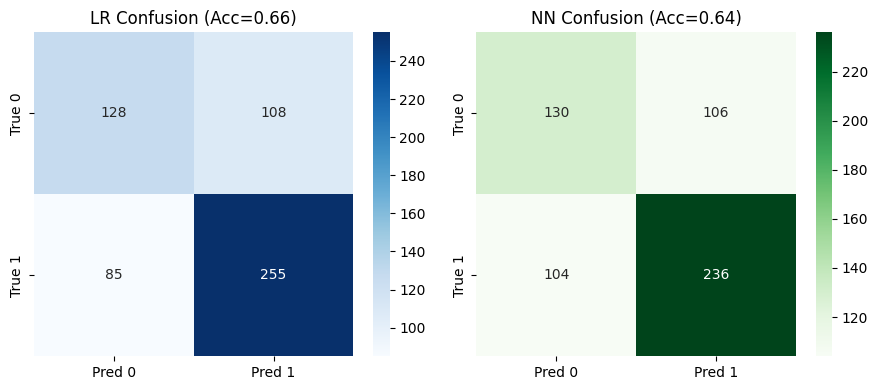

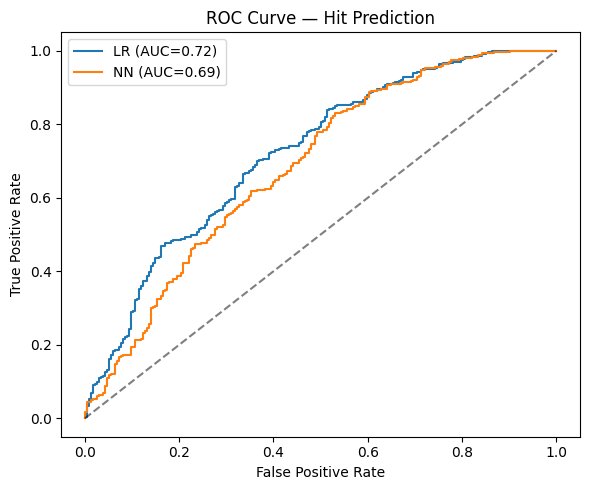

In [22]:
# 📊 Step 6 — Confusion Matrix + ROC Curve
# Confusion matrices
cm_lr = confusion_matrix(y_test, pred_lr)
cm_nn = confusion_matrix(y_test, pred_nn)

fig, axes = plt.subplots(1, 2, figsize=(9,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
axes[0].set_title(f"LR Confusion (Acc={acc_lr:.2f})")

sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Greens", ax=axes[1],
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
axes[1].set_title(f"NN Confusion (Acc={acc_nn:.2f})")
plt.tight_layout()
plt.savefig(os.path.join(OUT,"day17_confusions.png"), dpi=220)
plt.show()

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_nn, tpr_nn, _ = roc_curve(y_test, proba_nn)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={auc_lr:.2f})")
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC={auc_nn:.2f})")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Hit Prediction")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT,"day17_roc.png"), dpi=220)
plt.show()

             feature  importance_mean  importance_std
0  artist_popularity         0.172193        0.016502
5        duration_ms         0.012992        0.009153
2             energy         0.012790        0.012310
3           loudness         0.004826        0.008454
6     time_signature         0.000993        0.005932
4              tempo        -0.005450        0.010138
1       danceability        -0.009837        0.007544


/tmp/ipython-input-3827765077.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp.head(10), x="importance_mean", y="feature", palette="mako")


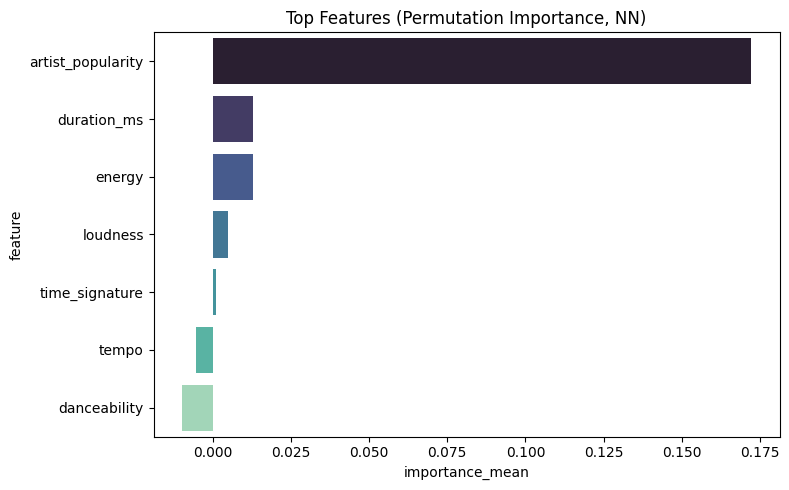

In [23]:
# Permutation importance on NN (slower but model-agnostic)
perm = permutation_importance(mlp, X_test_s, y_test, n_repeats=10, random_state=42, scoring="roc_auc")
imp = pd.DataFrame({
    "feature": feat_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp.head(10))

plt.figure(figsize=(8,5))
sns.barplot(data=imp.head(10), x="importance_mean", y="feature", palette="mako")
plt.title("Top Features (Permutation Importance, NN)")
plt.tight_layout()
plt.savefig(os.path.join(OUT,"day17_perm_importance.png"), dpi=220)
plt.show()


I will create a README file in the `day17_exports` folder with a basic structure. You can then edit this file to add more details about your project.

In [24]:
readme_content = """
# Spotify Hit Predictor

## Description
This project aims to predict whether a song will be a "hit" on Spotify based on its audio features and artist popularity.

## Data
The data used in this project is from the `playlist_2010to2023.csv` file, containing information about tracks and artists from 2010 to 2023.

## Methodology
The project involves data cleaning, feature selection, and training machine learning models (Logistic Regression and Neural Network) to predict song popularity.

## Results
The performance of the models is evaluated using metrics such as accuracy and AUC. Confusion matrices and ROC curves are generated to visualize the results.
"""

readme_path = os.path.join(OUT, "README.md")

with open(readme_path, "w") as f:
    f.write(readme_content)

print(f"README.md created successfully in {OUT}")

README.md created successfully in day17_exports
